In [1]:
# Import required packages
import os
import getpass
import asf_search as asf
import logging
import isce
root_logger = logging.getLogger()
root_logger.setLevel('WARNING')
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import time
from glob import glob
import scipy.signal

In [2]:
# Set environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)

## Define utilities

In [3]:
def select_pairs(scene_list, max_temp_bline):
    scene_dates = {}
    for scene in scene_list:
        date = scene[17:25]
        scene_dates[date] = scene
        
    pair_dict = {}
    pair_scenes = []
    for date1 in scene_dates:
        for date2 in scene_dates:
            if datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=max_temp_bline) and not date1 >= date2 :
                pair_dict[f'{date1}-{date2}'] = [scene_dates[date1], scene_dates[date2]]
                pair_scenes.append(scene_dates[date1])
                pair_scenes.append(scene_dates[date2])
    pair_scenes = [*set(pair_scenes)]
    
    print(f'number of pairs: {len(pair_dict)}')
    
    return pair_dict, pair_scenes

## Download SLCs

In [4]:
scene_list=['S1A_IW_SLC__1SDV_20210122T001129_20210122T001156_036243_044051_C4B5',
            'S1A_IW_SLC__1SDV_20201205T001132_20201205T001158_035543_0427F0_9243']

In [5]:
pair_dict, pair_scenes = select_pairs(scene_list, 80)

number of pairs: 1


In [6]:
proc_path = '/home/jovyan/ffits/nbs/imja/proc_DT121'

for pair in pair_dict:
    pair_path = f'{proc_path}/{pair}'
    if not os.path.exists(pair_path):
        os.makedirs(pair_path)

In [8]:
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

 ········


In [9]:
# Change to SLC directory
os.chdir(f'{proc_path}/slc')

results = asf.granule_search(pair_scenes)
session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
results.download(path=f'{proc_path}/slc', processes=2, session=session)

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/asf_search/download/download.py:62: UserWarning: File already exists, skipping download: /home/jovyan/ffits/nbs/imja/proc_DT121/slc/S1A_IW_SLC__1SDV_20210122T001129_20210122T001156_036243_044051_C4B5.zip
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/asf_search/download/download.py:62: UserWarning: File already exists, skipping download: /home/jovyan/ffits/nbs/imja/proc_DT121/slc/S1A_IW_SLC__1SDV_20210122T001129_20210122T001156_036243_044051_C4B5.iso.xml
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')


## Download orbits

In [10]:
os.chdir(f'{proc_path}/orbits')

In [11]:
%%bash

wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
chmod +x fetchOrbit.py

File ‘fetchOrbit.py’ already there; not retrieving.



In [12]:
# grab orbital files with fetchOrbit.py
for scene in pair_scenes:
    os.system(f'./fetchOrbit.py -i {scene}')

Reference time:  2020-12-05 00:11:58
Satellite name:  S1A
Reference time:  2021-01-22 00:11:56
Satellite name:  S1A


## Write config files

In [13]:
def generate_configs(pair_dict,
                     proc_path,
                     range_looks,
                     azimuth_looks,
                     aoi):
    
    for pair in pair_dict:
        os.chdir(f'{proc_path}/{pair}')

        reference = pair_dict[pair][0]
        secondary = pair_dict[pair][1]

        cmd_topsApp_config =f'''<?xml version="1.0" encoding="UTF-8"?>
        <topsApp>
          <component name="topsinsar">
            <property name="Sensor name">SENTINEL1</property>
            <component name="reference">
                <catalog>reference.xml</catalog>
            </component>
            <component name="secondary">
                <catalog>secondary.xml</catalog>
            </component>
            <property name="range looks">{range_looks}</property>
            <property name="azimuth looks">{azimuth_looks}</property>
            <property name="region of interest">{aoi}</property>
            <property name="do unwrap">True</property>
            <property name="unwrapper name">snaphu_mcf</property>
            <property name="do denseoffsets">True</property>
            <property name="geocode list">['merged/phsig.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat','merged/topophase.cor','merged/filt_topophase.unw.conncomp']</property>
          </component>
        </topsApp>'''
        print("writing topsApp.xml")
        with open("topsApp.xml", "w") as fid:
            fid.write(cmd_topsApp_config)

        cmd_reference_config = f'''<component name="reference">
            <property name="orbit directory">{proc_path}/orbits</property>
            <property name="output directory">reference</property>
            <property name="safe">['{proc_path}/slc/{reference}.zip']</property>
        </component>'''
        print("writing reference.xml")
        with open("reference.xml", "w") as fid:
            fid.write(cmd_reference_config)

            cmd_secondary_config = f'''<component name="secondary">
            <property name="orbit directory">{proc_path}/orbits</property>
            <property name="output directory">secondary</property>
            <property name="safe">['{proc_path}/slc/{secondary}.zip']</property>
        </component>'''
        print("writing secondary.xml")
        with open("secondary.xml", "w") as fid:
            fid.write(cmd_secondary_config)

In [14]:
generate_configs(pair_dict=pair_dict,
                proc_path=proc_path,
                range_looks=7,
                azimuth_looks=3,
                aoi=[27.58, 28.13, 86.28, 87.32])

writing topsApp.xml
writing reference.xml
writing secondary.xml


## run ISCE

In [15]:
%%time
for pair in pair_dict:
    os.chdir(f'{proc_path}/{pair}')
    #if not os.path.exists(f'{proc_path}/{pair}/merged/filt_topophase.unw.geo'):
    !topsApp.py --start=preprocess --end=geocode

2023-07-25 11:48:35,570 - isce.insar - INFO - ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.3, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20230418, CURRENT_SVN_REVISION = 

2023-07-25 11:48:35,626 - isce.insar - WARNING - Some filenames in insarApp.geocode_list configuration are different from those in InsarProc. Using names given to insarApp.
insarApp.geocode_list = ['merged/phsig.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat', 'merged/topophase.cor', 'merged/filt_topophase.unw.conncomp']
InsarProc.geocode_list = ['merged/phsig.cor', 'merged/topophase.cor', 'merged/filt_topophase.unw', 'merged/los.rdr', 'merged/topophase.flat', 'merged/filt_topophase.flat', 'merged/filt_topophase_2stage.unw']
Step processing
Cannot open PICKLE/startup
Running step preprocess
Input XML files:  ['/vsizip//home/jovyan/ffits/nbs/imja/proc_DT121/slc/S1A_IW_SLC__1SDV_20201205T001132_20

## Plot files

In [16]:
def isce_to_ds(path):
    
    unw_phase_path = glob(f'{path}/merged/filt_topophase.unw.geo.vrt')[0]
    dem_path = glob(f'{path}/merged/dem.crop.vrt')[0]
    w_phase_path = glob(f'{path}/merged/filt_topophase.flat.geo.vrt')[0]
    corr_path = glob(f'{path}/merged/topophase.cor.geo.vrt')[0]
    conncomp_path = glob(f'{path}/merged/filt_topophase.unw.conncomp.geo.vrt')[0]
    
    ds = rioxarray.open_rasterio(unw_phase_path).isel(band=1).to_dataset(name='unw_phase')
    dem_da = rioxarray.open_rasterio(dem_path)
    w_phase_da = rioxarray.open_rasterio(w_phase_path)
    corr_da = rioxarray.open_rasterio(corr_path).isel(band=1)
    conncomp_da = rioxarray.open_rasterio(conncomp_path)
    
    ds['elevation'] = (('y', 'x'), dem_da.squeeze().values)
    ds['w_phase'] = (('y', 'x'), np.angle(w_phase_da.squeeze()))
    ds['coherence'] = (('y', 'x'), corr_da.squeeze().values)
    ds['conncomp'] = (('y', 'x'), conncomp_da.squeeze().values)
    
    ds = ds.rio.reproject(ds.rio.estimate_utm_crs())
    
    return ds

In [17]:
ds = isce_to_ds('/home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122')

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


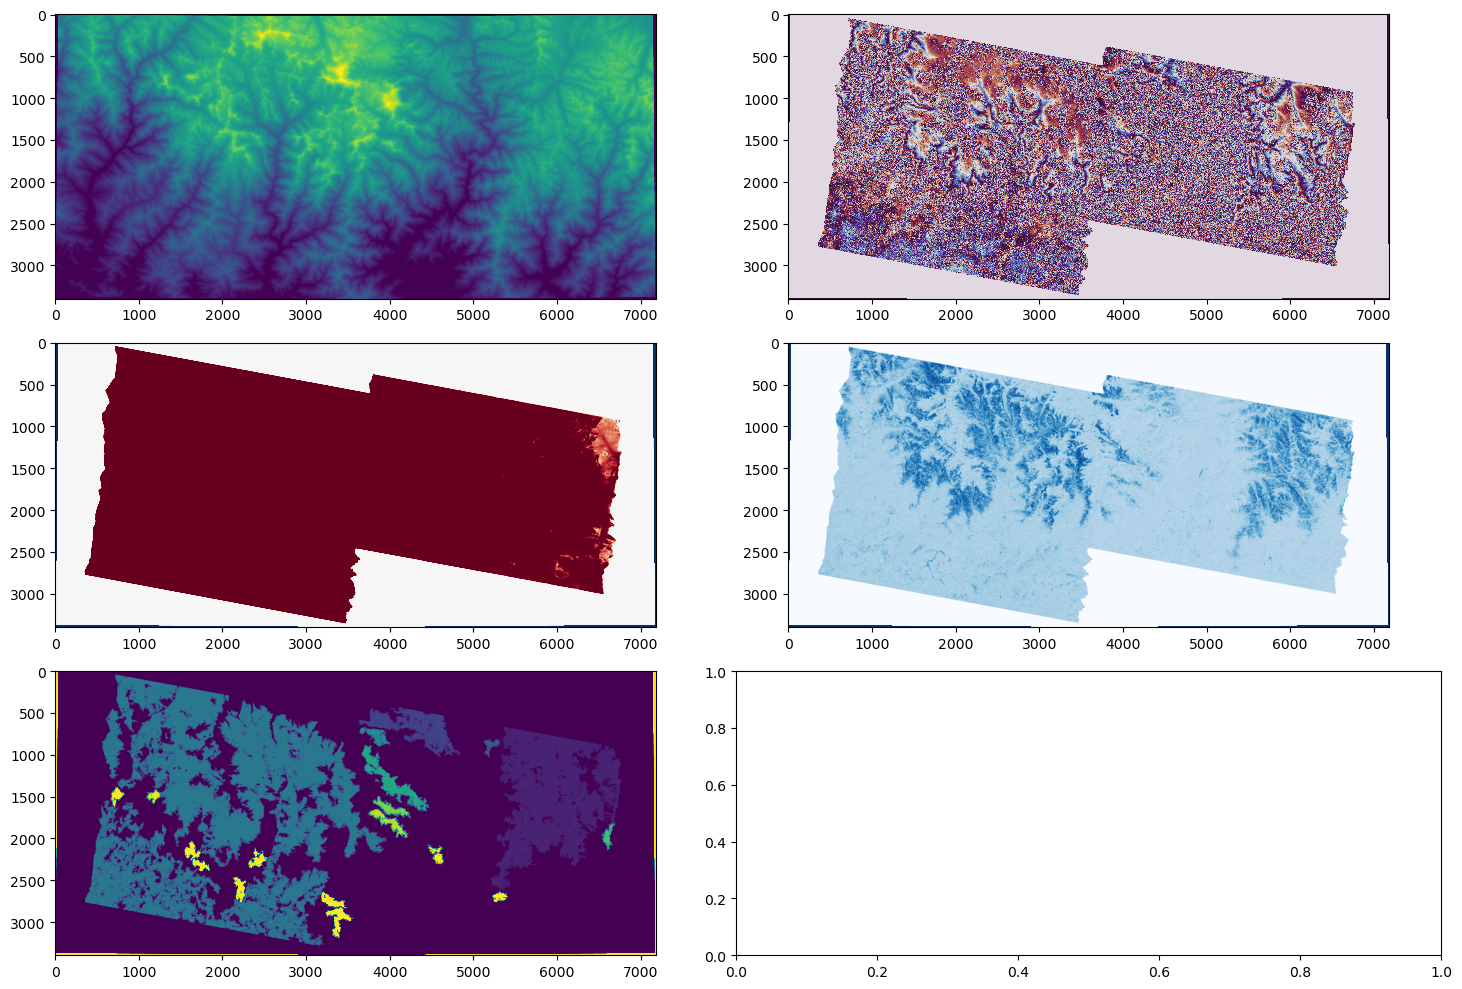

In [18]:
f, ax = plt.subplots(3, 2, figsize=(15, 10))
ax[0, 0].imshow(ds.elevation, vmin=1000, vmax=8000, cmap='viridis')
ax[0, 0].set_aspect('equal')

ax[0, 1].imshow(ds.w_phase, vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 1].set_aspect('equal')

ax[1, 0].imshow(ds.unw_phase, vmin=-10, vmax=10, cmap='RdBu')
ax[1, 0].set_aspect('equal')

ax[1, 1].imshow(ds.coherence, vmin=0, vmax=1, cmap='Blues')
ax[1, 1].set_aspect('equal')

ax[2, 0].imshow(ds.conncomp, vmax=10, cmap='viridis')
ax[2, 0].set_aspect('equal')

f.tight_layout()

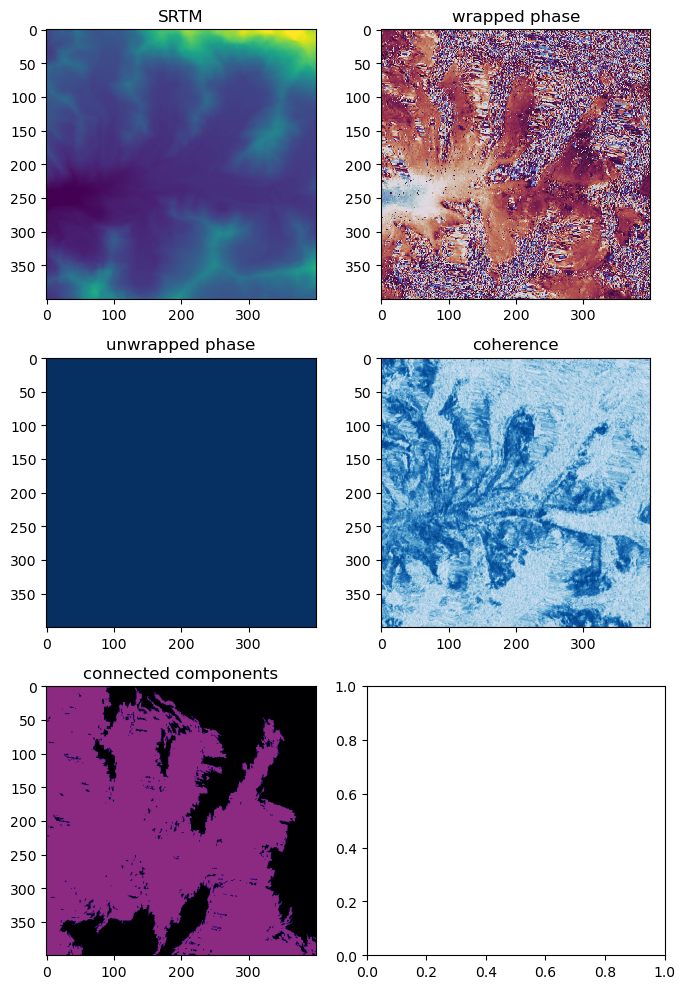

In [19]:
subset = {'y':slice(800, 1200), 'x':slice(3100, 3500)}

f, ax = plt.subplots(3, 2, figsize=(7, 10))
ax[0, 0].imshow(ds.elevation.isel(subset), vmin=4500, vmax=8000, cmap='viridis')
ax[0, 0].set_aspect('equal')
ax[0, 0].set_title('SRTM')

ax[0, 1].imshow(ds.w_phase.isel(subset), vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_title('wrapped phase')

ax[1, 0].imshow(ds.unw_phase.isel(subset), vmin=-29, vmax=-9, cmap='RdBu_r')
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title('unwrapped phase')

ax[1, 1].imshow(ds.coherence.isel(subset), vmin=0, vmax=1, cmap='Blues')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title('coherence')

ax[2, 0].imshow(ds.conncomp.isel(subset), vmax=10, cmap='magma')
ax[2, 0].set_aspect('equal')
ax[2, 0].set_title('connected components')

f.tight_layout()

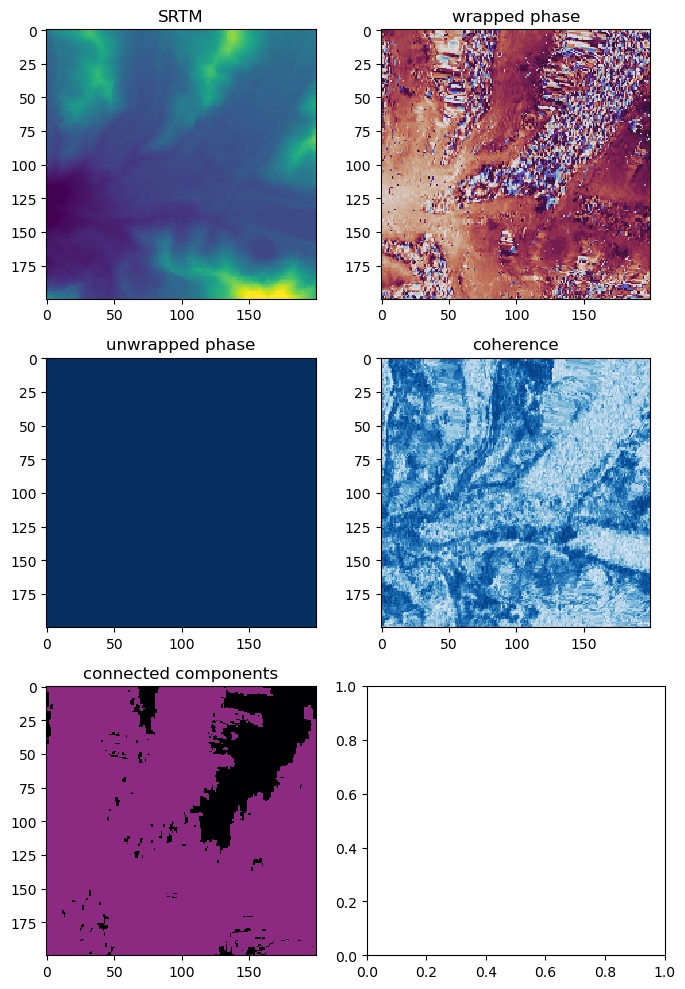

In [20]:
subset = {'y':slice(900, 1100), 'x':slice(3200, 3400)}

f, ax = plt.subplots(3, 2, figsize=(7, 10))
ax[0, 0].imshow(ds.elevation.isel(subset), vmin=4700, vmax=5900, cmap='viridis', interpolation='none')
ax[0, 0].set_aspect('equal')
ax[0, 0].set_title('SRTM')

ax[0, 1].imshow(ds.w_phase.isel(subset), vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 1].set_aspect('equal')
ax[0, 1].set_title('wrapped phase')

ax[1, 0].imshow(ds.unw_phase.isel(subset), vmin=-29, vmax=-9, cmap='RdBu_r', interpolation='none')
ax[1, 0].set_aspect('equal')
ax[1, 0].set_title('unwrapped phase')

ax[1, 1].imshow(ds.coherence.isel(subset), vmin=0, vmax=1, cmap='Blues', interpolation='none')
ax[1, 1].set_aspect('equal')
ax[1, 1].set_title('coherence')

ax[2, 0].imshow(ds.conncomp.isel(subset), vmax=10, cmap='magma', interpolation='none')
ax[2, 0].set_aspect('equal')
ax[2, 0].set_title('connected components')

f.tight_layout()

## Amplitude feature tracking

In [21]:
# open coregistered SLCs
def isce_to_np(path):
    unw_phase_path = glob(f'{path}/merged/reference.slc.full.vrt')[0]
    dem_path = glob(f'{path}/merged/secondary.slc.full.vrt')[0]
    
    ref_np = np.abs(rioxarray.open_rasterio(unw_phase_path).squeeze().values)
    sec_np = np.abs(rioxarray.open_rasterio(dem_path).squeeze().values)
    
    return ref_np, sec_np

In [22]:
ref, sec = isce_to_np('/home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122')

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [ ]:
# f, ax = plt.subplots(2, 1)
# ax[0].imshow(ref, vmin=0, vmax=100)
# ax[1].imshow(sec, vmin=0, vmax=100)

In [8]:
# # install autoRIFT in notebook environment
# import sys
# !mamba install --yes --prefix {sys.prefix} autorift
# !{sys.executable} -m pip install opencv-python-headless


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.2) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['autorift']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━━╸━━━━━━━━━━━   0.0 B /  ??.?MB @  ??

In [12]:
from autoRIFT import autoRIFT_ISCE

In [24]:
# setup autoRIFT parameters
obj = autoRIFT()
obj.I1 = ref
obj.I2 = sec
    
# define chip size ranges
## Kernel sizes to use for correlation
obj.ChipSizeMinX = 16
obj.ChipSizeMaxX = 128

# check and refine this
obj.ChipSize0X = 16

# skip rate setup
# Produce output at a grid x time the input resolution 
obj.SkipSampleX = 4
obj.SkipSampleY = 4

# preprocess to bring out edges in the image
prefilter_choice = 'lap'
walis_filter_width = 3
if not prefilter_choice == 'none':
    obj.WallisFilterWidth = walis_filter_width
    if prefilter_choice == 'db':
        print(f"####### Using DB preprocessing with a window width of {walis_filter_width} #######")
        obj.preprocess_db()
    elif prefilter_choice == 'lap':
        print(f"####### Using a laplician filter with a window width of {walis_filter_width} #######")
        obj.preprocess_filt_lap()
    elif prefilter_choice == 'sob':
        print(f"####### Using a Sobel filter with a window width of {walis_filter_width} #######")
        obj.preprocess_filt_sob()
    elif prefilter_choice == 'wal':
        print(f"####### Using a Walis filter with a window width of {walis_filter_width} #######")
        obj.preprocess_filt_wal()
else:
    print("##### No preprocessing #####")
    
convert8bit = True
# converting to 8 bit and then performing correlation is a faster approach
print(f"convert8bit option is {convert8bit}")
if convert8bit:
    print("####### Downcasting to 8 bit#######")
    obj.uniform_data_type()

print("creating correlation grid")
# create the grid if it does not exist (from test_autoRIFT.py)
m,n = obj.I1.shape
xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY) 
nd = xGrid.__len__()
md = yGrid.__len__()
obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
noDataMask = np.logical_not(obj.xGrid)

####### Using a laplician filter with a window width of 3 #######


/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:339: RuntimeWarning: divide by zero encountered in log10
  self.I1 = 20.0 * np.log10(self.I1)
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:342: RuntimeWarning: divide by zero encountered in log10
  self.I2 = 20.0 * np.log10(self.I2)


convert8bit option is True
####### Downcasting to 8 bit#######
creating correlation grid


In [25]:
# run autorift
print("####### Executing autoRIFT correlation #######")
obj.runAutorift()

####### Executing autoRIFT correlation #######


/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:1824: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:1825: RuntimeWarning: divide by zero encountered in divide
  DyMadmin = np.ones(Dy.shape) / OverSampleRatio / SearchLimitY * 2
/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/autoRIFT/autoRIFT.py:1758: RuntimeWarning: Mean of empty slice
  C = np.nanmean(B, axis=0)


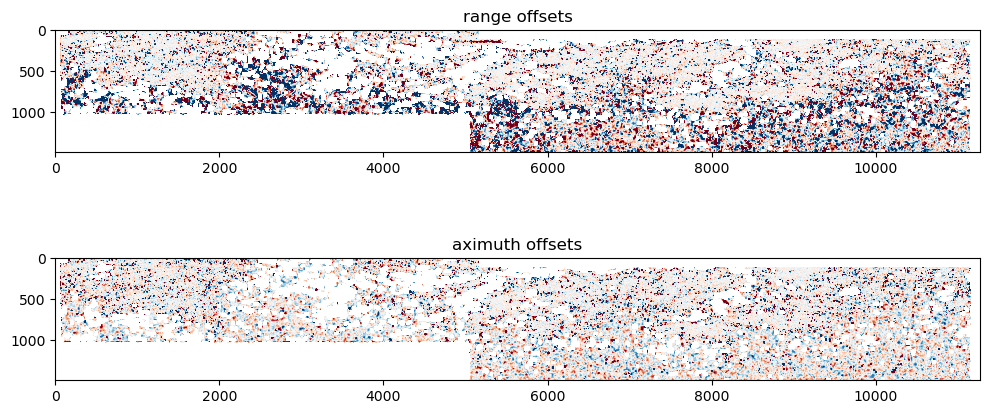

In [26]:
f,ax = plt.subplots(2, 1, figsize=(10, 5))
im = ax[0].imshow(obj.Dx, cmap='RdBu', vmin=-0.2, vmax=0.2, aspect=4)
ax[0].set_title('range offsets')
ax[0].set_aspect('equal')
im = ax[1].imshow(obj.Dy ,cmap='RdBu', vmin=-0.2, vmax=0.2, aspect=4)
ax[1].set_title('aximuth offsets')
ax[1].set_aspect('equal')
#plt.colorbar(im, label='pixels')
plt.tight_layout()

#plt.savefig('./figs/karakoram_xyoffsets.png', dpi=300)

In [27]:
# save to isce rasters
path = '/home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122'

# save to isce rasters
azimuth_offsets = xr.DataArray(obj.Dy,
                               coords={'y':np.arange(obj.Dy.shape[0], 0, -1), 'x':np.arange(0, obj.Dy.shape[1])},
                               dims=['y', 'x'])
                               
range_offsets = xr.DataArray(obj.Dx,
                             coords={'y':np.arange(obj.Dx.shape[0], 0, -1), 'x':np.arange(0, obj.Dx.shape[1])},
                             dims=['y', 'x'])

azimuth_offsets.rio.to_raster(f'{path}/merged/azimuth_offsets_raw', driver='ISCE')
range_offsets.rio.to_raster(f'{path}/merged/range_offsets_raw', driver='ISCE')

In [14]:
path = '/home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122'

In [15]:
os.chdir(path)

In [17]:
# build vrts and multilook offsets
!gdalbuildvrt $f'{path}/merged/azimuth_offsets_raw.vrt' $f'{path}/merged/azimuth_offsets_raw'
!looks.py -i $f'{path}/merged/azimuth_offsets_raw' -r 7 -a 3 -o $f'{path}/merged/azimuth_offsets_raw.lks'
!gdalbuildvrt $f'{path}/merged/range_offsets_raw.vrt' $f'{path}/merged/range_offsets_raw'
!looks.py -i $f'{path}/merged/range_offsets_raw' -r 7 -a 3 -o $f'{path}/merged/range_offsets_raw.lks'

0...10...20...30...40...50...60...70...80...90...100 - done.
Output filename : /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
GDAL open (R): /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.vrt
API open (WR): /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
GDAL close: /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.vrt
API close:  /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
API open (R): /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
API close:  /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
Writing geotrans to VRT for /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
0...10...20...30...40...50...60...70...80...90...100 - done.
Output filename : /home/jovyan/ffits/nbs/imja/pr

In [28]:
# build vrts and multilook offsets
!gdalbuildvrt /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.vrt /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw
!looks.py -i /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw -r 7 -a 3 -o /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
!gdalbuildvrt /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/range_offsets_raw.vrt /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/range_offsets_raw
!looks.py -i /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/range_offsets_raw -r 7 -a 3 -o /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/range_offsets_raw.lks

0...10...20...30...40...50...60...70...80...90...100 - done.
Output filename : /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
GDAL open (R): /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.vrt
API open (WR): /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
GDAL close: /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.vrt
API close:  /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
API open (R): /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
API close:  /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
Writing geotrans to VRT for /home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122/merged/azimuth_offsets_raw.lks
0...10...20...30...40...50...60...70...80...90...100 - done.
Output filename : /home/jovyan/ffits/nbs/imja/pr

## load offsets with wrapped phase

In [3]:
path = '/home/jovyan/ffits/nbs/imja/proc_DT121/20201205-20210122'
w_phase_path = glob(f'{path}/merged/filt_topophase.flat.vrt')[0]
range_offsets_path = glob(f'{path}/merged/range_offsets_raw.lks.vrt')[0]

In [4]:
ds = rioxarray.open_rasterio(w_phase_path).to_dataset(name='w_phase').squeeze()

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/rioxarray/_io.py:924: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [5]:
ds['w_phase'] = (('y', 'x'), np.angle(ds.w_phase.squeeze()))

In [6]:
ro_da = rioxarray.open_rasterio(range_offsets_path).squeeze()

In [7]:
# grab coord ranges from wrapped phase
ro_da = ro_da.assign_coords(x=np.linspace(ds.w_phase.x.min(), ds.w_phase.x.max(), num= len(ro_da.x)),
                            y=np.linspace(ds.w_phase.y.min(), ds.w_phase.y.max(), num= len(ro_da.y)))

In [8]:
ds['range_offsets'] = (('y', 'x'), ro_da.interp_like(ds.w_phase).values)

In [9]:
# convert range offset to phase. pixel spacing=2.3
ds['range_offsets_phase'] = (ds.range_offsets*2.3*4*np.pi)/0.05546576

In [10]:
# filter range offset
def prep_for_filter(da):
    
    array = da.values
    distance_from_mean = abs(array - np.mean(array))
    max_deviations = 2
    not_outlier = distance_from_mean < max_deviations * np.std(array)
    da = da.where(not_outlier) #filter outliers
    
    da = da.interpolate_na(dim='x', use_coordinate=False) # interpolate small gaps
    da = da.interpolate_na(dim='y', use_coordinate=False)
   

    array = np.nan_to_num(da, 0) # set nans to 0
    
    return array
    
def butterLow(cutoff, critical, order):
    normal_cutoff = float(cutoff) / critical
    b, a = scipy.signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butterFilter(data, cutoff_freq, nyq_freq, order):
    b, a = butterLow(cutoff_freq, nyq_freq, order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

#cutoff_frequency = 300
#sample_rate = 460*2+1

cutoff_frequency = 300
sample_rate = 10000*2+1

filtered = butterFilter(prep_for_filter(ds.range_offsets_phase), cutoff_freq=cutoff_frequency, nyq_freq=sample_rate/2, order=2)

ds['range_offsets_filtered'] = (('y', 'x'), filtered)

In [11]:
# wrap offsets 
wrapped = np.subtract(np.mod(ds.range_offsets_filtered,2*np.pi), np.pi)
ds['range_offsets_wrapped'] = (('y', 'x'), wrapped.values)

<bound method Figure.tight_layout of <Figure size 1200x800 with 4 Axes>>

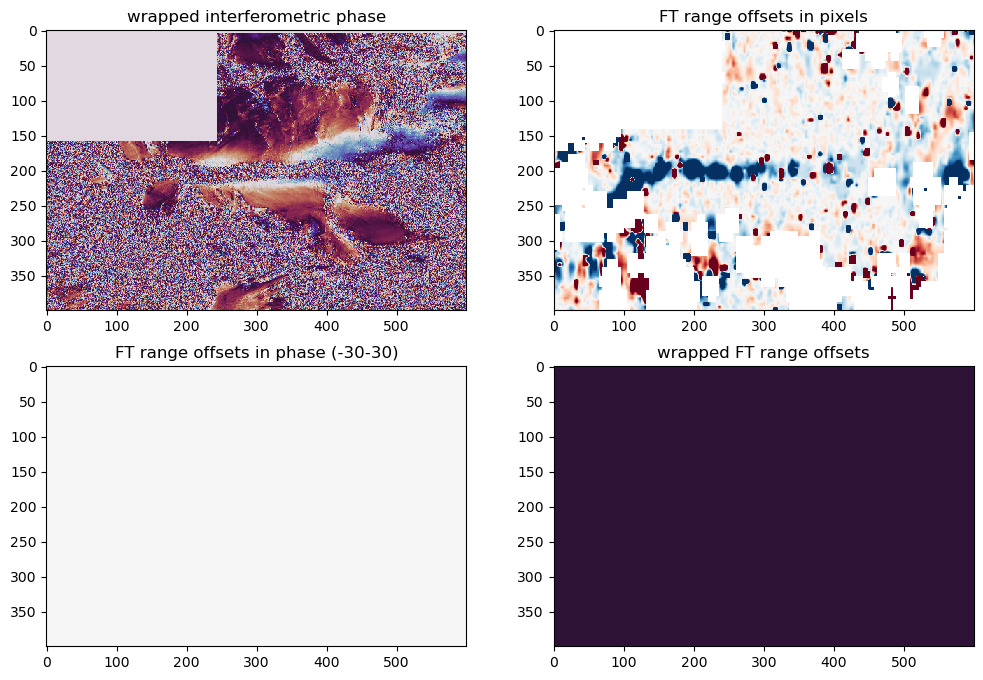

In [14]:
subset = {'y':slice(0, 400), 'x':slice(2600, 3200)}
#subset = {'y':slice(200, 700), 'x':slice(2800, 4200)}
#subset = {'y':slice(300, 600), 'x':slice(3200, 3600)}

f, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].imshow(np.flip(ds.w_phase.isel(subset), axis=1), vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[0, 0].set_title('wrapped interferometric phase')
ax[0, 1].imshow(np.flip(ds.range_offsets.isel(subset), axis=1), vmin=-0.3, vmax=0.3, cmap='RdBu_r', interpolation='none')
ax[0, 1].set_title('FT range offsets in pixels')
ax[1, 0].imshow(np.flip(ds.range_offsets_filtered.isel(subset), axis=1), vmin=-100, vmax=100, cmap='RdBu_r', interpolation='none')
ax[1, 0].set_title('FT range offsets in phase (-30-30)')
ax[1, 1].imshow(np.flip(ds.range_offsets_wrapped.isel(subset), axis=1), vmin=-np.pi, vmax=np.pi, cmap='twilight_shifted', interpolation='none')
ax[1, 1].set_title('wrapped FT range offsets')

f.tight_layout

## load and plot multiple FT results

In [2]:
ft_paths = glob('./proc_DT121/*/merged/range_offsets_phase.vrt')

In [16]:
rioxarray.open_rasterio(ft_paths[2])

<xarray.DataArray (band: 1, y: 1549, x: 6444)>
[9981756 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 6.442e+03 6.442e+03 6.444e+03
  * y            (y) float64 1.548e+03 1.548e+03 1.546e+03 ... 2.5 1.5 0.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0